In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
from sqlalchemy import create_engine, MetaData, Table, select, and_

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
conn = engine.connect()
# reflect the tables
# Reflect the tables from the database into a new model
Base = automap_base()

# Use the engine to reflect the database
Base.prepare(engine, reflect=True)


/var/folders/0h/qqmkr3rs5s72v4bnyvq7v1xr0000gn/T/ipykernel_48672/4246676656.py:8: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
# Print the classes mapped to the tables
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01',)

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date 1 year prior to the last data point in the database
latest_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
start_date = latest_date - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores

# Perform a query to retrieve the sum of the precipitation amount (across all stations) by date
# Sort the result by date
sel = [Measurement.date, 
       func.sum(Measurement.prcp)]
prec = session.query(*sel).\
        filter(func.strftime(Measurement.date) >= start_date).\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names

measurement_df = pd.DataFrame(prec, columns=['measurement_date', 'precipitation_amount'])
measurement_df.dropna(axis=0, how='any', inplace= True)

# Sort the dataframe by date
measurement_df.sort_values(by='measurement_date')
measurement_df.set_index('measurement_date', inplace=True)


# Use Pandas Plotting with Matplotlib to plot the data


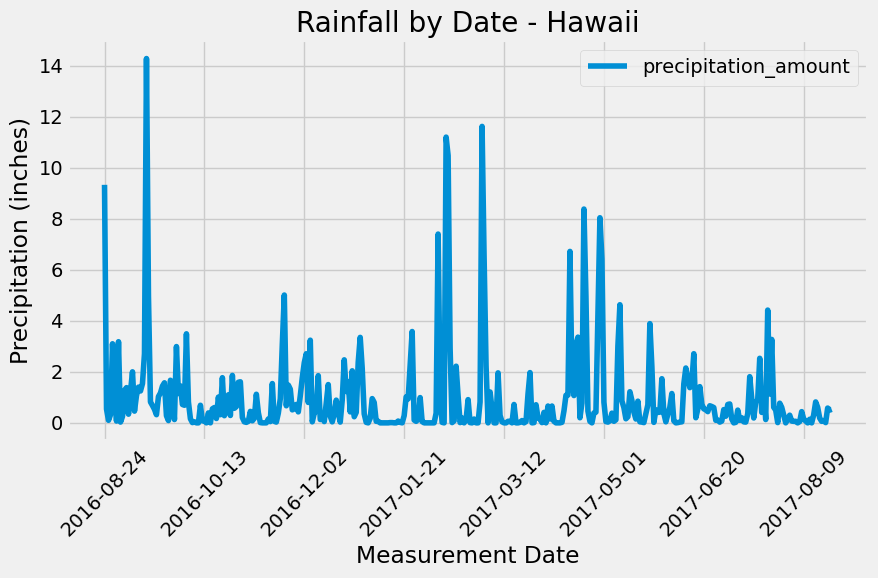

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
chart = measurement_df.plot(rot=45, title = "Rainfall by Date - Hawaii", xlabel='Measurement Date', ylabel = "Precipitation (inches)", figsize=(9,6))
# precipitation_df.plot(rot=45)
plt.tight_layout()
plt.show()
chart.figure.savefig('Annual_Precipitation_Hawaii.png', bbox_inches='tight')

# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Measurement.station)).all()

In [ ]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [Measurement.station, 
       func.count(Measurement.date)]
active_stations = session.query(*sel).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.date).desc()).all()
active_stations

In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station,
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
station_temp_summary = session.query(*sel).\
        filter(Measurement.station == 'USC00519281').\
        group_by(Measurement.station)
for station in station_temp_summary:
    print(station)

In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.date, 
       Measurement.tobs]
station_temps = session.query(*sel).\
        filter(func.strftime(Measurement.date) >= start_date, Measurement.station == 'USC00519281').\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()

# Create a datafrem containing the results of this query
station_temps_df = pd.DataFrame(station_temps, columns=['Measurement Date', 'Temperature'])
station_temps_df.head()

In [ ]:
# Create a histogram to visualize the temperature observations from Station USC00519281 

plt.hist(station_temps_df['Temperature'],bins=12, density=False, label="TOBS")
plt.xlabel("Temperature (Fahrenheit)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Temperature Observations at USC00519281")
plt.figsize=(10,7)
plt.savefig('Annual_Temps_USC00519281.png',bbox_inches='tight')
plt.show()

# Close Session

In [ ]:
# Close Session
session.close()